In [1]:
import pandas as pd 
import numpy as np 
import scipy
# import xlrd 
import sklearn

from Gibbs_model_probit import Gibbs_sampling

from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from utils import baseline_lr,baseline_esnet,baseline_justmean
from utils import baseline_LogitElsnet,baseline_justmode,baseline_random,baseline_LogitLR,baseline_RanForest,baseline_Gibbs_zhe,baseline_SVM
from utils import baseline_LogitElsnet_leaveone,baseline_LogitLR_leaveone,baseline_SVM_leaveone

from sklearn.model_selection import KFold
from scipy.stats import binom 
from scipy.stats import norm
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from tqdm import trange
from Gibbd_zhe import GibbsSampling3
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut
import time
from sklearn.preprocessing import StandardScaler

In [2]:
# data_loading 
np.random.seed(123)
data_table = pd.read_csv('../data/processed/all_feature_p1_lip_specie.csv')
target = '1= death; 0=alive'#'gap_surv_time_class' 'ADT_if_fail'


# normalization

# min-max
df = data_table[target]


# check nan
data_table[target].isnull().values.any()
# data_table.fillna(data_table.mean(), inplace=True) # fill nan with column mean

False

In [3]:
all_feature = data_table.iloc[:,1:-7]
#lip_feature = data_table.iloc[:,1:775]#for p2
# lip_feature = data_table.iloc[:,1:-372]#for p1
# gene_feature = data_table.iloc[:,775:-7]#for p1

Y = data_table[target].values
X = all_feature.values
# X = gene_feature.values


In [47]:
target = 'gap_surv_time_class'# 'ADT_if_fail'
Y = data_table[target].values

In [42]:
# # leave-one test
# loo = LeaveOneOut()
# X = X_r
# N = loo.get_n_splits(X)

# lr_acc = np.zeros(N)
# esnet_acc = np.zeros(N)
# mode_acc = np.zeros(N)
# random_acc = np.zeros(N)
# svm_acc = np.zeros(N)




# for i,index in enumerate(loo.split(X)):
#     train_index, test_index = index
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = Y[train_index], Y[test_index]
#     data_dict = {'X_tr':X_train, 'y_tr':y_train, 'X_test':X_test, 'y_test':y_test}
#     dict_lr = baseline_LogitLR_leaveone(data_dict)
#     dict_els = baseline_LogitElsnet_leaveone(data_dict)
#     # dict_rf = baseline_RanForest(data_dict)
#     dict_mode = baseline_justmode(data_dict)
#     dict_random = baseline_random(data_dict)
#     dict_svm = baseline_SVM_leaveone(data_dict)

#     lr_acc[i] = dict_lr['acr']
#     esnet_acc[i] = dict_els['acr']

#     mode_acc[i] = dict_mode['acr']
#     random_acc[i] = dict_random['acr']
#     svm_acc[i] = dict_svm['acr']

# print('lr_acr_mean: %.4f,lr_acr_std: %.4f '%(lr_acc.mean(),lr_acc.std() ) )
# print('esnet_acr_mean: %.4f,esnet_acr_std: %.4f '%(esnet_acc.mean(),esnet_acc.std() ) )
# print('svm_acr_mean: %.4f,rf_acr_mean: %.4f '%(svm_acc.mean(),svm_acc.std() ) )
# print('just-mode_acr_mean: %.4f,mode_acr_std: %.4f '%(mode_acc.mean(),mode_acc.std() ) )
# print('just-random_acr_mean: %.4f,just-random_acr_std: %.4f '%(random_acc.mean(),random_acc.std() ) )

In [6]:
# PCA analysis

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

lw = 2
scaler = StandardScaler()
X_new = scaler.fit_transform(X)

pca = PCA(n_components=40)
X_r = pca.fit(X_new).transform(X_new)
colors = ['navy',  'darkorange']
target_names = ['dead','live']

# for color, i, target_name in zip(colors, [0, 1], target_names):
#     plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.8, lw=lw,
#                 label=target_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1)
# plt.title('PCA of p1_dead_or_live (with all lip and gene feature)')
# plt.show()
pca.singular_values_
# singular_values_ of first 20 principle-components

array([99.15746794, 87.18260882, 63.55015609, 59.80190566, 54.40850358,
       51.17352303, 46.79407981, 41.80528152, 40.50997029, 39.08714688,
       35.00463777, 32.88229918, 32.66098587, 30.84613214, 28.79176509,
       27.89614401, 27.23800097, 27.13401071, 26.750207  , 26.09024581,
       24.88725571, 24.50331433, 23.34055363, 23.24239025, 22.13317765,
       21.92723578, 21.56740129, 21.02630004, 20.591577  , 20.26710648,
       20.08454722, 19.40433633, 19.28310208, 19.05053608, 18.34280593,
       17.58885087, 17.15527958, 17.02492874, 16.6910411 , 16.66954364])

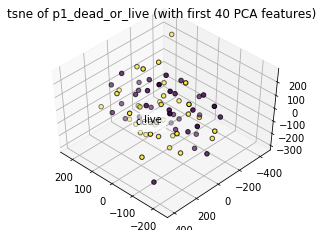

In [35]:
# visulize the x_r with t-sne, target：dead or live
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
X_embedded = TSNE(n_components=3).fit_transform(X_r)
colors = ['navy',  'darkorange']
target_names = ['dead','live']
# X_embedded.shape
target = '1= death; 0=alive'# 'ADT_if_fail'
Y = data_table[target].values

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)


for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.text3D(X_embedded[Y == i, 0].mean(),
              X_embedded[Y == i, 1].mean() + 200.5,
              X_embedded[Y == i, 2].mean(), target_name,
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

# Y= map(float,Y)
y = np.choose(Y.astype(int), [1, 0])
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y,
           edgecolor='k')
#     plt.scatter(X_embedded[Y == i, 0], X_embedded[Y == i, 1], color=color, alpha=.8, lw=lw,
#                 label=target_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('tsne of p1_dead_or_live (with first 40 PCA features)')
plt.show()

In [24]:
y

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0])

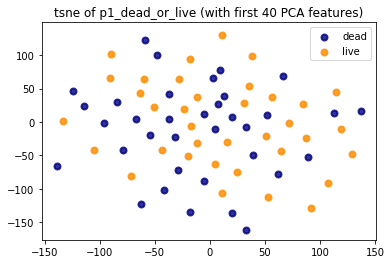

In [7]:
# visulize the x_r with t-sne, target：dead or live
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_r)
colors = ['navy',  'darkorange']
target_names = ['dead','live']
# X_embedded.shape
target = '1= death; 0=alive'# 'ADT_if_fail'
Y = data_table[target].values


for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_embedded[Y == i, 0], X_embedded[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('tsne of p1_dead_or_live (with first 40 PCA features)')
plt.show()

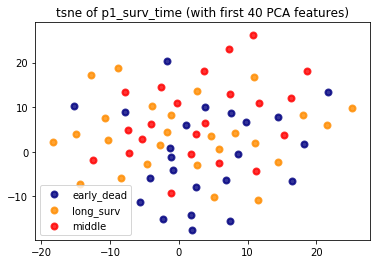

In [75]:
#  visulize the x_r with t-sne, target：surv_time
from sklearn.manifold import TSNE

target = 'gap_surv_time_class'# 'ADT_if_fail'
Y = data_table[target].values


# X_embedded = TSNE(n_components=2).fit_transform(X_r)
colors = ['navy',  'darkorange', 'red']
target_names = ['early_dead','long_surv','middle']
# X_embedded.shape

for color, i, target_name in zip(colors, [0, 1,2], target_names):
    plt.scatter(X_embedded[Y == i, 0], X_embedded[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('tsne of p1_surv_time (with first 40 PCA features)')
plt.show()

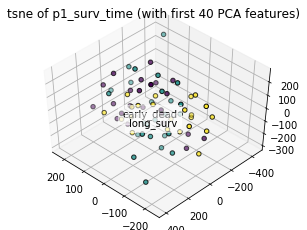

In [38]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

target = 'gap_surv_time_class'# 'ADT_if_fail'
Y = data_table[target].values
target_names = ['early_dead','long_surv','middle']

for color, i, target_name in zip(colors, [0, 1,2], target_names):
    ax.text3D(X_embedded[Y == i, 0].mean(),
              X_embedded[Y == i, 1].mean() + 200.5,
              X_embedded[Y == i, 2].mean(), target_name,
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

# Y= map(float,Y)
y = np.choose(Y.astype(int), [0,1,2])
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y,
           edgecolor='k')
#     plt.scatter(X_embedded[Y == i, 0], X_embedded[Y == i, 1], color=color, alpha=.8, lw=lw,
#                 label=target_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('tsne of p1_surv_time (with first 40 PCA features)')
plt.show()

F:\anaconda\conda\envs\pt\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
F:\anaconda\conda\envs\pt\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


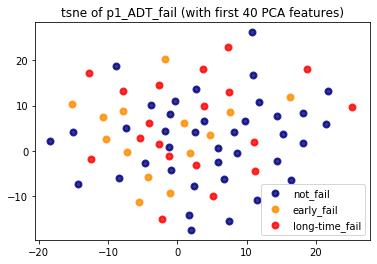

In [76]:
#  visulize the x_r with t-sne, target：ADT_fail
from sklearn.manifold import TSNE

target = 'ADT_start_fail'
Y = data_table[target].values
Y_new = np.zeros(len(Y)) 
Y_new[np.argwhere(Y>=0)]=1
Y_new[np.argwhere(Y>365)]=2


# X_embedded = TSNE(n_components=2).fit_transform(X_r)
colors = ['navy',  'darkorange', 'red']
target_names = ['not_fail','early_fail','long-time_fail']
# X_embedded.shape

for color, i, target_name in zip(colors, [0.0, 1,2], target_names):
    plt.scatter(X_embedded[Y_new == i, 0], X_embedded[Y_new == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('tsne of p1_ADT_fail (with first 40 PCA features)')
plt.show()

F:\anaconda\conda\envs\pt\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
F:\anaconda\conda\envs\pt\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


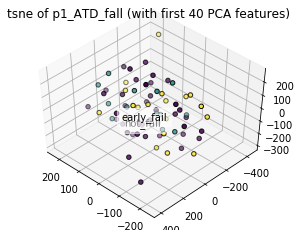

In [39]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)


target = 'ADT_start_fail'
Y = data_table[target].values
Y_new = np.zeros(len(Y)) 
Y_new[np.argwhere(Y>=0)]=1
Y_new[np.argwhere(Y>365)]=2

target_names = ['not_fail','early_fail','long-time_fail']

for color, i, target_name in zip(colors, [0, 1,2], target_names):
    ax.text3D(X_embedded[Y_new == i, 0].mean(),
              X_embedded[Y_new == i, 1].mean() + 200.5,
              X_embedded[Y_new == i, 2].mean(), target_name,
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

# Y= map(float,Y)
y = np.choose(Y_new.astype(int), [0,1,2])
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y,
           edgecolor='k')
#     plt.scatter(X_embedded[Y == i, 0], X_embedded[Y == i, 1], color=color, alpha=.8, lw=lw,
#                 label=target_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('tsne of p1_ATD_fall (with first 40 PCA features)')
plt.show()

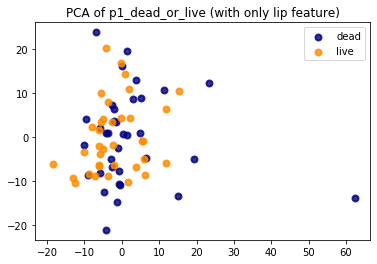

In [20]:
lw = 2
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
colors = ['navy',  'darkorange']
target_names = ['dead','live']

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of p1_dead_or_live (with only lip feature)')
plt.show()

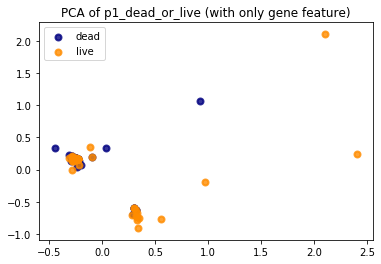

In [25]:
lw = 2
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
colors = ['navy',  'darkorange']
target_names = ['dead','live']

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of p1_dead_or_live (with only gene feature)')
plt.show()

In [37]:

N = 3
lr_acc = np.zeros(N)
rf_acc = np.zeros(N)
esnet_acc = np.zeros(N)
mode_acc = np.zeros(N)
random_acc = np.zeros(N)
ours_acc = np.zeros(N)
zhe_gibs_acc = np.zeros(N)

lr_auc = np.zeros(N)
rf_auc = np.zeros(N)
esnet_auc = np.zeros(N)
ours_auc = np.zeros(N)
zhe_gibs_auc = np.zeros(N)

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X_new, Y.squeeze(),test_size=0.3)

    data_dict = {'X_tr':X_train, 'y_tr':y_train, 'X_test':X_test, 'y_test':y_test}  
    dict_lr = baseline_LogitLR(data_dict)
    dict_els = baseline_LogitElsnet(data_dict)
    dict_rf = baseline_RanForest(data_dict)
    dict_mode = baseline_justmode(data_dict)
    dict_random = baseline_random(data_dict)
    dict_gibbs_zhe = baseline_Gibbs_zhe(data_dict,hyper_paras)

    # model = Gibbs_sampling(data_dict,get_init_paras(dict_lr['clf'].coef_.squeeze()), hyper_paras)
    model = Gibbs_sampling(data_dict,zero_init_paras(), hyper_paras)
    dict_ours = model.model_run()

    lr_acc[i] = dict_lr['acr']
    esnet_acc[i] = dict_els['acr']
    rf_acc[i] = dict_rf['acr']
    mode_acc[i] = dict_mode['acr']
    random_acc[i] = dict_random['acr']
    ours_acc[i] = dict_ours['acr']
    zhe_gibs_acc[i] = dict_gibbs_zhe['acr']

    lr_auc[i] = dict_lr['auc']
    rf_auc[i] = dict_rf['auc']
    esnet_auc[i] = dict_els['auc']
    ours_auc[i] = dict_ours['auc']
    zhe_gibs_auc[i] = dict_gibbs_zhe['auc']

print('\n\nours_acr_mean: %.4f,ours_acr_std: %.4f '%( ours_acc.mean(), ours_acc.std() ) )
print('gibbs_zhe_acr_mean: %.4f,gibbs_zhe_acr_std: %.4f '%(zhe_gibs_acc.mean(),zhe_gibs_acc.std() ) )
print('lr_acr_mean: %.4f,lr_acr_std: %.4f '%(lr_acc.mean(),lr_acc.std() ) )
print('esnet_acr_mean: %.4f,esnet_acr_std: %.4f '%(esnet_acc.mean(),esnet_acc.std() ) )
print('rf_acr_mean: %.4f,rf_acr_mean: %.4f '%(rf_acc.mean(),rf_acc.std() ) )
print('just-mode_acr_mean: %.4f,mode_acr_std: %.4f '%(mode_acc.mean(),mode_acc.std() ) )
print('just-random_acr_mean: %.4f,just-random_acr_std: %.4f '%(random_acc.mean(),random_acc.std() ) )


print('\nours_AUC_mean: %.4f,ours_AUC_std: %.4f '%(ours_auc.mean(),ours_auc.std() ) )
print('gibbs_zhe_AUC_mean: %.4f,gibbs_zhe_AUC_std: %.4f '%(zhe_gibs_auc.mean(),zhe_gibs_auc.std() ) )
print('lr_AUC_mean: %.4f,lr_AUC_std: %.4f '%(lr_auc.mean(),lr_auc.std() ) )
print('esnet_AUC_mean: %.4f,esnet_AUC_mean: %.4f '%(esnet_auc.mean(),esnet_auc.std() ) )
print('rf_AUC_mean: %.4f,rf_AUC_std: %.4f '%(rf_auc.mean(),rf_auc.std() ) )



 3.20it/s]ours:W_max:31.4637,W_min:-28.7030
 90%|█████████ | 90/100 [00:27<00:03,  3.18it/s]ours:W_max:34.7218,W_min:-29.4597

 running test-auc = 0.45089
running train-auc = 1.00000

100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


 final test auc = 0.75000, acr = 0.50000


 final test auc_full = 0.71429, acr_full = 0.50000
C:\Users\Tianfan Wu\Documents\Python Scripts\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
for LogitLR: accuracy is 0.772727, auc is 0.783333,  fpr is 0.300000
C:\Users\Tianfan Wu\Documents\Python Scripts\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
for LogitElsnet: accuracy is 0.772727, auc is 0.783333,  fpr is 0.300000
C:\Users\Tianfan Wu\Documents\Python Scripts\lib\site-packages\sklearn

[array([1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1

In [22]:
# non-sparse feature of the last samples
len(np.where(np.concatenate((model.W))>0)[0])

581

In [28]:
# non-sparse feature of the mean of all samples (no truncated)
N_collect = len(model.W_collect)
if N_collect > 0:
    W_samples = np.zeros((N_collect,model.N_feature))
    for i in range(N_collect):
        W_samples[i,:-1] = np.concatenate((model.W_collect[i]))
        W_samples[i,-1] = model.b_collect[i]

    W_avg = np.mean(W_samples,axis=0).reshape(-1,1)
len(np.where(np.abs(W_avg)>0.01)[0])

1132

In [37]:
N_collect = len(model.W_collect)
if N_collect > 0:
    # W_samples = np.zeros((N_collect,model.N_feature))
    W_samples = np.zeros((model.N_feature,N_collect))
    for i in range(N_collect):
        W_samples[:-1,i] = np.concatenate((model.W_collect[i]))
        W_samples[-1,i] = model.b_collect[i]

    # W_avg = np.mean(W_samples,axis=0).reshape(-1,1)
W_samples.shape    

(1140, 30)

In [16]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
clf = LogisticRegressionCV(l1_ratios =[.001,.01, .1, .5, .7, .9, .95, .99, 1],penalty='elasticnet',solver='saga',fit_intercept=False).fit(data_dict['X_tr'],data_dict['y_tr'])


C:\Users\Tianfan Wu\Documents\Python Scripts\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Tianfan Wu\Documents\Python Scripts\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Tianfan Wu\Documents\Python Scripts\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Tianfan Wu\Documents\Python Scripts\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Tianfan Wu\Documents\P

In [19]:
clf.C_

array([21.5443469])

In [32]:
# non-sparse feature of the Gibbs_zhe
dict_gibbs_zhe['model'][1][:, -10:].

(1140, 10)